In [ ]:
import os
import requests
import zipfile


In [2]:
from pathlib import Path

coco_path = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download")


train_path = coco_path / "train2017"
val_path= coco_path / "val2017"
annotations_path = coco_path / "annotations"

# data is not zipped, 

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from pathlib import Path

class CocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file=None, transform=None):
        self.image_dir = Path(image_dir)
        self.image_paths = sorted(self.image_dir.glob("*.jpg"))  # Load all JPGs
        self.transform = transform
        self.annotations = None
        
        if annotations_file:
            with open(annotations_file, "r") as f:
                self.annotations = json.load(f)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Return image only (modify if annotations are needed)
        return image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate datasets
train_dataset = CocoDataset(train_path, transform=transform)
val_dataset = CocoDataset(val_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Example batch
sample_batch = next(iter(train_loader))
print(sample_batch.shape)  # Should print [32, 3, 256, 256]

print(sample_batch[0].shape)  # Should print [32, 3, 256, 256]


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 3, 256, 256])


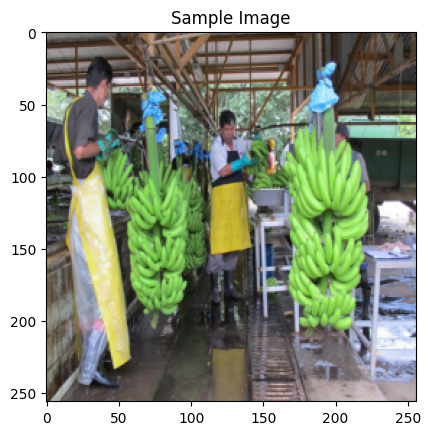

In [5]:
# show image
import matplotlib.pyplot as plt
import numpy as np
def imshow(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()
imshow(sample_batch[0], title="Sample Image")

In [26]:
# list one annotation
import json
from pathlib import Path

# Load COCO annotation file
annotations_file = annotations_path / "instances_train2017.json"  # Change to val2017 if needed

with open(annotations_file, "r") as f:
    coco_data = json.load(f)

# Extract key data
images = coco_data["images"]  # List of image metadata
annotations = coco_data["annotations"]  # List of object annotations
categories = coco_data["categories"]  # List of category mappings

category_id_to_name = {cat['id']: cat['name'] for cat in categories}
category_to_images = {}
# Create a mapping of category IDs to image IDs
for ann in annotations:
    category_id = ann['category_id']
    image_id = ann['image_id']
    if category_id not in category_to_images:
        category_to_images[category_id] = []
    category_to_images[category_id].append(image_id)


annotation_counts_per_image = {}
for ann in annotations:
    image_id = ann['image_id']
    if image_id not in annotation_counts_per_image:
        annotation_counts_per_image[image_id] = 0
    annotation_counts_per_image[image_id] += 1
    
# List the first 5 image metadata entries
print("First 5 Images Metadata:")
for img in images[:5]:
    print(f"ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

# List the first 5 annotations
print("\nFirst 5 Annotations:")
for ann in annotations[:5]:
    category = ann["category_id"]
    category_name = category_id_to_name.get(category, "Unknown")
    
    print(f"Image ID: {ann['image_id']}, Category: {ann['category_id']}, BBox: {ann['bbox']} -- {category_name}")


# List category mapping
print("\nCategories:")
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")



First 5 Images Metadata:
ID: 391895, File: 000000391895.jpg, Size: 640x360
ID: 522418, File: 000000522418.jpg, Size: 640x480
ID: 184613, File: 000000184613.jpg, Size: 500x336
ID: 318219, File: 000000318219.jpg, Size: 556x640
ID: 554625, File: 000000554625.jpg, Size: 426x640

First 5 Annotations:
Image ID: 558840, Category: 58, BBox: [199.84, 200.46, 77.71, 70.88] -- hot dog
Image ID: 200365, Category: 58, BBox: [234.22, 317.11, 149.39, 38.55] -- hot dog
Image ID: 200365, Category: 58, BBox: [239.48, 347.87, 160.0, 57.81] -- hot dog
Image ID: 200365, Category: 58, BBox: [296.65, 388.33, 1.03, 0.0] -- hot dog
Image ID: 200365, Category: 58, BBox: [251.87, 333.42, 125.94, 22.71] -- hot dog

Categories:
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15,

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


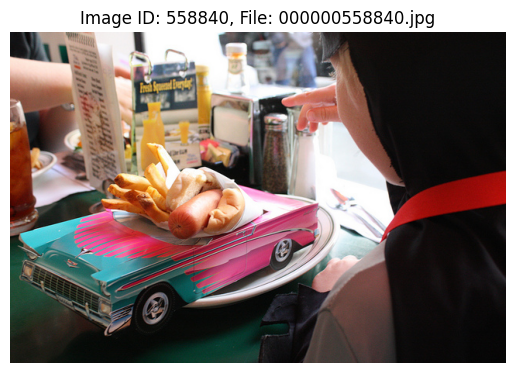

In [19]:
print(coco_data.keys())
# show image 558840
def show_image(image_id):
    # Find the image metadata
    image_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)
    if not image_info:
        print(f"Image ID {image_id} not found.")
        return

    # Load the image
    img_path = train_path / image_info["file_name"]
    image = Image.open(img_path).convert("RGB")

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image ID: {image_id}, File: {image_info['file_name']}")
    plt.show()
id_ = 558840
show_image(id_)

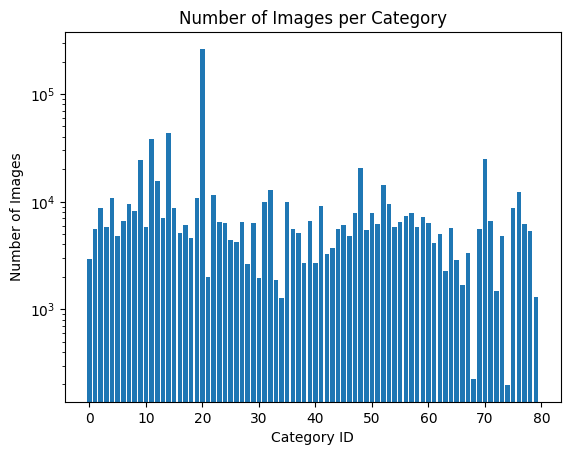

In [23]:
#categories
# plot hist of category_to_images counts
import matplotlib.pyplot as plt
counts = [len(image_ids) for image_ids in category_to_images.values()]
# plot bars
plt.bar(range(len(counts)), counts)
plt.xlabel('Category ID')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.yscale('log')
plt.show()

In [25]:
# print top 3 and bottom 3 categories
top_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]), reverse=True)[:3]
bottom_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]))[:3]
print("Top 3 Categories:")
for cat_id, image_ids in top_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} : Count: {len(image_ids)}")
print("\nBottom 3 Categories:")
for cat_id, image_ids in bottom_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} :  Count: {len(image_ids)}")

Top 3 Categories:
Category ID: 1, person : Count: 262465
Category ID: 3, car : Count: 43867
Category ID: 62, chair : Count: 38491

Bottom 3 Categories:
Category ID: 89, hair drier :  Count: 198
Category ID: 80, toaster :  Count: 225
Category ID: 14, parking meter :  Count: 1285


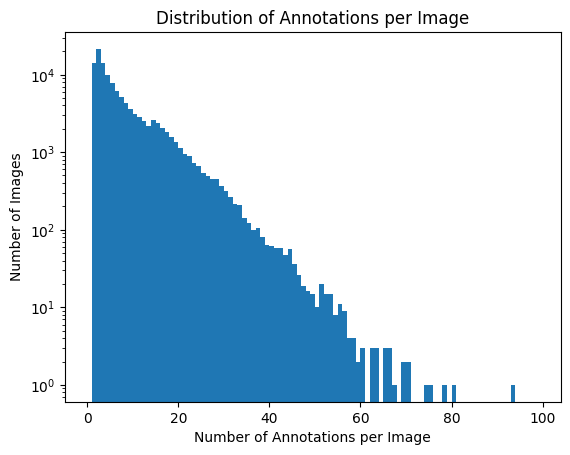

In [31]:
# plot annotation_counts_per_image
# plot hist of annotation_counts_per_image.values()
# bins 0 to 100
bins = np.arange(0, 100, 1)

plt.hist(list(annotation_counts_per_image.values()), bins = bins)#, bins=np.arange(1, 20), log=True)
plt.xlabel('Number of Annotations per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Annotations per Image')
plt.yscale('log')
plt.show()

In [ ]:
coco_data["categories"]
coco_data["annotations"][0]
    